# WBC Quality control

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [3]:
from ehv.core import plot_gate_zarr, plot_gate_zarr_channels

In [4]:
from umap import UMAP
import time
import math
import pyarrow.parquet as pq
from scip.masking import threshold
from scip.masking import util
from scip.features import texture
import zarr

## Load processed frame

In [20]:

data_dir = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/results/scip/202204271347")
df = pq.read_table(data_dir / "features.parquet").to_pandas()

In [21]:
df.filter(regex="meta")

meta_path  meta_zarr_idx  \
0       /data/gent/vo/000/gvo00070/vsc42015/datasets/w...           3000   
1       /data/gent/vo/000/gvo00070/vsc42015/datasets/w...           3001   
2       /data/gent/vo/000/gvo00070/vsc42015/datasets/w...           3002   
3       /data/gent/vo/000/gvo00070/vsc42015/datasets/w...           3003   
4       /data/gent/vo/000/gvo00070/vsc42015/datasets/w...           3004   
...                                                   ...            ...   
274045  /data/gent/vo/000/gvo00070/vsc42015/datasets/w...          21725   
274046  /data/gent/vo/000/gvo00070/vsc42015/datasets/w...          21726   
274047  /data/gent/vo/000/gvo00070/vsc42015/datasets/w...          21727   
274048  /data/gent/vo/000/gvo00070/vsc42015/datasets/w...          21728   
274049  /data/gent/vo/000/gvo00070/vsc42015/datasets/w...          21729   

        meta_object_number meta_group meta_part meta_fix  meta_bbox_minr  \
0                    14993          2         3     None             0.0   
1                    14995          2         3     None             0.0   
2                    14996          2         3     None             0.0   
3                    14997          2         3     None             0.0   
4                    14999          2         3     None             0.0   
...                    ...        ...       ...      ...             ...   
274045                9992          4         1     late             0.0   
274046                9994          4         1     late            15.0   
274047                9995          4         1     late             0.0   
274048                9996          4         1     late             0.0   
274049                9997          4         1     late             0.0   

        meta_bbox_minc  meta_bbox_maxr  meta_bbox_maxc  ...  \
0                  0.0            60.0            54.0  ...   
1                  0.0            69.0            63.0  ...   
2                  0.0            77.0            64.0  ...   
3                  0.0            84.0            55.0  ...   
4                  0.0            82.0            64.0  ...   
...                ...             ...             ...  ...   
274045             0.0            49.0            50.0  ...   
274046            14.0            63.0            54.0  ...   
274047             0.0            49.0            54.0  ...   
274048             0.0            66.0            57.0  ...   
274049             0.0            84.0            63.0  ...   

        meta_regions_CD19  meta_regions_SSC  meta_regions_CD3  \
0                     9.0               1.0               1.0   
1                     0.0               1.0               1.0   
2                    15.0               1.0               1.0   
3                    14.0               1.0               1.0   
4                     0.0               1.0               1.0   
...                   ...               ...               ...   
274045                1.0               1.0               1.0   
274046                0.0               1.0               1.0   
274047                0.0               1.0               1.0   
274048               10.0               1.0               1.0   
274049               12.0               1.0               1.0   

        meta_regions_CD45  meta_regions_BF2  meta_regions_CD4  \
0                     1.0               1.0               1.0   
1                     1.0               1.0               6.0   
2                     1.0               1.0               7.0   
3                     1.0               1.0               1.0   
4                     1.0               1.0               7.0   
...                   ...               ...               ...   
274045                1.0               1.0               1.0   
274046                1.0               1.0               1.0   
274047                1.0               1.0               1.0   
274048                1.0         

In [22]:

cat_type = CategoricalDtype(categories=sorted(df["meta_group"].astype(int).unique()), ordered=True)
df["meta_group"] = df["meta_group"].astype(int).astype(cat_type)
cat_type = CategoricalDtype(categories=sorted(df["meta_part"].astype(int).unique()), ordered=True)
df["meta_part"] = df["meta_part"].astype(int).astype(cat_type)

In [23]:
df = df.set_index(["meta_group", "meta_part", "meta_fix", "meta_object_number"])

## No bounding box

In [24]:
# images that have no bounding box
df = df[~df.filter(regex="bbox").isna().any(axis=1)]
df.shape

(247993, 2515)

# Number of identified regions per channel 

/apps/gent/RHEL8/zen2-ib/software/SciPy-bundle/2021.10-foss-2021b/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


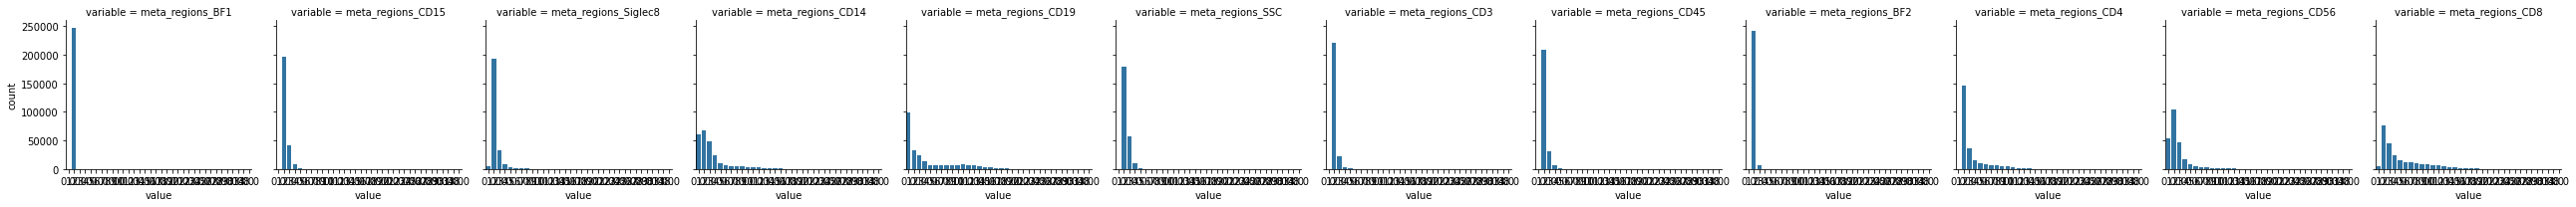

In [26]:
tmp = pandas.melt(df, value_vars=df.filter(regex="regions").columns)
tmp["value"] = tmp["value"].astype("category")
grid = seaborn.FacetGrid(data=tmp, col="variable")
grid.map_dataframe(seaborn.countplot, x="value")

In [27]:
sel = ((df["meta_regions_BF1"] == 1) & (df["meta_regions_BF2"] == 1))

In [30]:
df = df[sel]
df.shape

(241275, 2515)

# NaN values

In [31]:
# show all NaN columns
df.columns[df.isna().all(axis=0)]

Index([], dtype='object')

# Texture features

Many NaN values occur for features that have no default value for when no mask is found. This occurs in texture and shape features.

In [11]:
def compute_glcm(r, bbox_channel_index=0, smooth=0.75):
    z = zarr.open(r.meta_path)
    pixels = z[r.meta_zarr_idx].reshape(z.attrs["shape"][r.meta_zarr_idx])
    pixels = numpy.clip(pixels, a_min=0, a_max=4096)

    m = threshold.get_mask(dict(pixels=pixels), main=True, main_channel=bbox_channel_index, smooth=smooth)
    m = util.get_bounding_box(m)
    m = threshold.get_mask(m, main=False, main_channel=bbox_channel_index, smooth=smooth)
    m = util.remove_regions_touching_border(m, bbox_channel_index=bbox_channel_index)
    m = util.apply(m)

    fig, axes = plt.subplots(2, len(pixels), dpi=150, squeeze=False)
    for i, (a, p) in enumerate(zip(m["mask"], pixels)):
        axes[0, i].imshow(a)
        axes[0, i].set_axis_off()
        axes[1, i].imshow(p)
        axes[1, i].set_axis_off()
        
    m = texture.texture_features(m, 4096)
        
    return m, fig

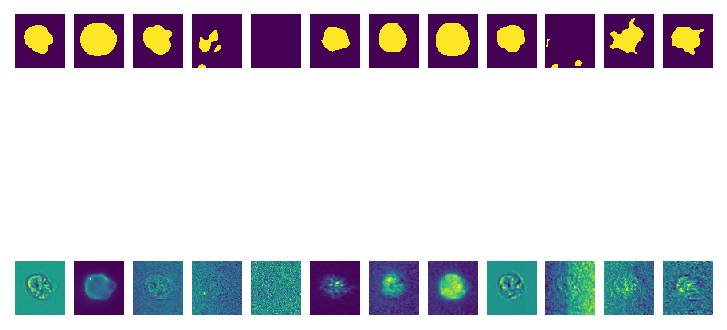

In [12]:
r = df[df.filter(regex="glcm").isna().any(axis=1)].iloc[0]
m, fig = compute_glcm(r, smooth=1.5)

In [47]:
cols = df.filter(regex="glcm").columns[df.filter(regex="glcm").isna().any()]

In [48]:
glcms = pandas.DataFrame(list(map(lambda a: re.match(r"feat_?(?P<comb>combined)?_glcm_(?P<type>[^_]+)_(?P<name>[^_]+)_(?P<dist>[0-9])_(?P<channel>.+)$", a).groupdict(), cols)))

In [49]:
glcms["channel"].unique()

array(['CD15', 'Siglec8', 'CD14', 'CD19', 'SSC', 'CD3', 'CD45', 'BF2',
       'CD4', 'CD56', 'CD8'], dtype=object)

In [50]:
glcms["dist"].value_counts()

3    132
5    132
Name: dist, dtype: int64

In [51]:
glcms.groupby("dist")["type"].value_counts()

dist  type
3     mean    66
      std     66
5     mean    66
      std     66
Name: type, dtype: int64

In [52]:
glcms.groupby("dist")["name"].value_counts()

dist  name         
3     ASM              22
      contrast         22
      correlation      22
      dissimilarity    22
      energy           22
      homogeneity      22
5     ASM              22
      contrast         22
      correlation      22
      dissimilarity    22
      energy           22
      homogeneity      22
Name: name, dtype: int64

In [53]:
glcms.groupby("channel")["name"].value_counts()

channel  name         
BF2      ASM              4
         contrast         4
         correlation      4
         dissimilarity    4
         energy           4
                         ..
Siglec8  contrast         4
         correlation      4
         dissimilarity    4
         energy           4
         homogeneity      4
Name: name, Length: 66, dtype: int64

In [54]:
df = df.drop(columns=cols)

In [55]:
cols = df.filter(regex="sobel").columns[df.filter(regex="sobel").isna().any()]

In [56]:
df = df.drop(columns=cols)

# All cells must have strictly positive SSC and BF area

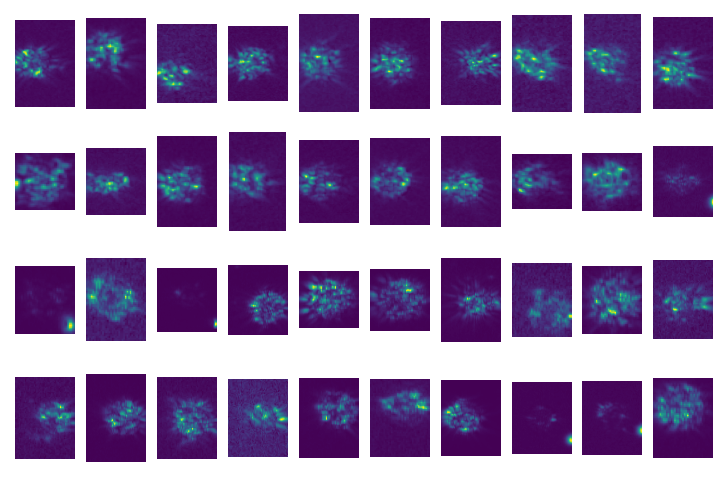

In [33]:
sel1 = df["feat_area_SSC"] == 0
core.plot_gate_zarr(sel1, df, channel=5, maxn=40)

In [34]:
df = df[~sel1]
df.shape

(240817, 2515)

In [36]:
sel1 = df["feat_area_BF1"] == 0
if sum(sel1) > 0:
    core.plot_gate_zarr(sel1, df, channel=0, maxn=40)

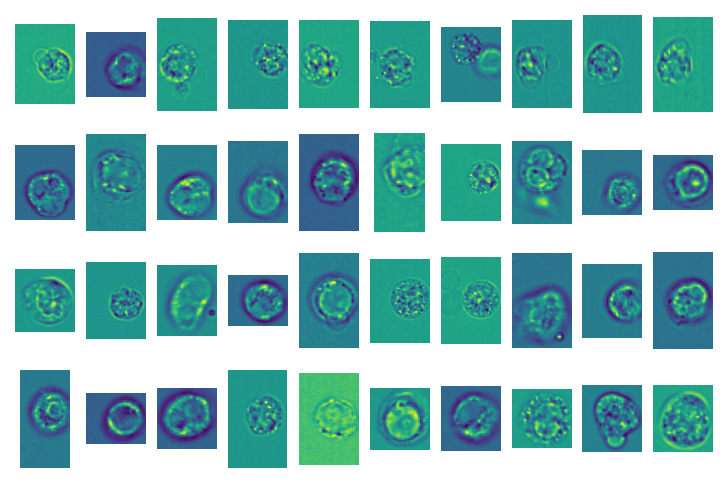

In [37]:
sel1 = df["feat_area_BF2"] == 0
core.plot_gate_zarr(sel1, df, channel=0, maxn=40)

In [38]:
df = df[~sel1]
df.shape

(240243, 2515)

# Detecting multiplets that are missed during segmentation

<AxesSubplot:xlabel='feat_major_axis_length_BF1', ylabel='feat_minor_axis_length_BF1'>

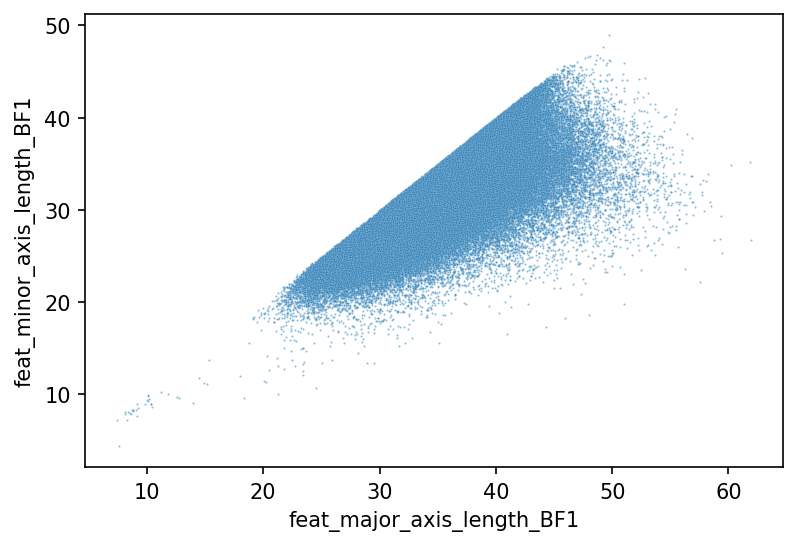

In [39]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(ax=ax, data=df, x="feat_major_axis_length_BF1", y="feat_minor_axis_length_BF1", s=1, alpha=0.5)

<AxesSubplot:xlabel='feat_major_axis_length_CD15', ylabel='feat_minor_axis_length_CD15'>

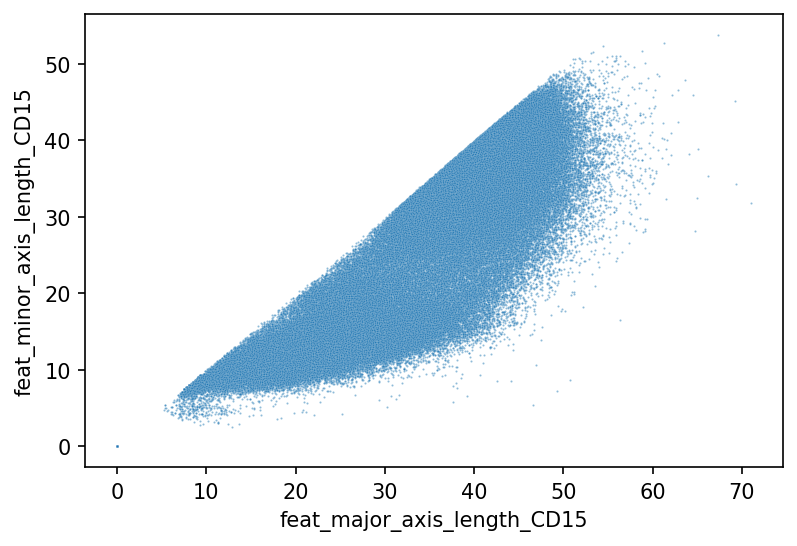

In [40]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(ax=ax, data=df, x="feat_major_axis_length_CD15", y="feat_minor_axis_length_CD15", s=1, alpha=0.5)

<AxesSubplot:xlabel='feat_major_axis_length_Siglec8', ylabel='feat_minor_axis_length_Siglec8'>

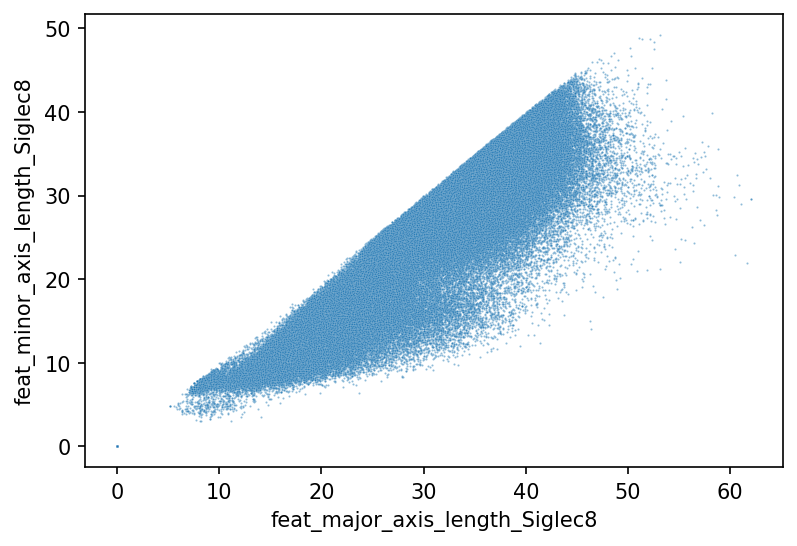

In [41]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(ax=ax, data=df, x="feat_major_axis_length_Siglec8", y="feat_minor_axis_length_Siglec8", s=1, alpha=0.5)

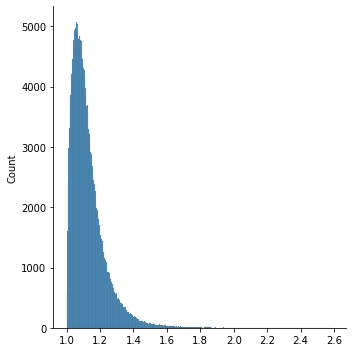

In [42]:
feat_majorminor_ratio = df["feat_major_axis_length_BF1"] / df["feat_minor_axis_length_BF1"]
ax = seaborn.displot(data=feat_majorminor_ratio)

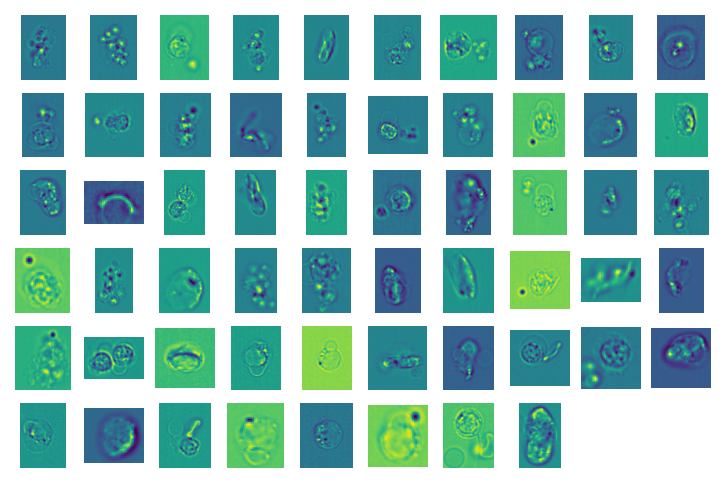

In [43]:
sel1 = feat_majorminor_ratio > 2
plot_gate_zarr(sel1, df)

In [44]:
df = df[~sel1]
df.shape

(240185, 2515)

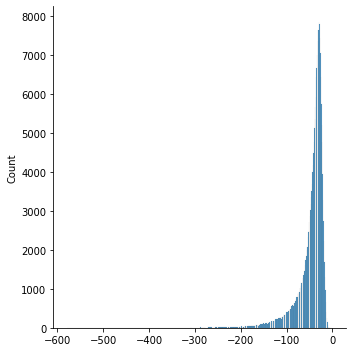

In [45]:
seaborn.displot(data=df["feat_area_BF1"] - df["feat_convex_area_BF1"])

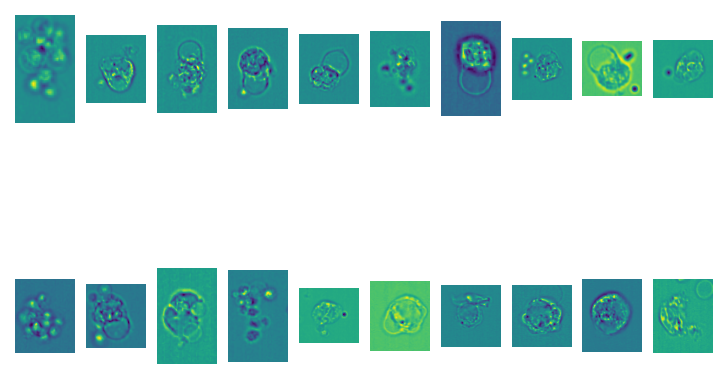

In [46]:
sel1 = (df["feat_area_BF1"] - df["feat_convex_area_BF1"]) < -300
core.plot_gate_zarr(sel1, df, maxn=20)

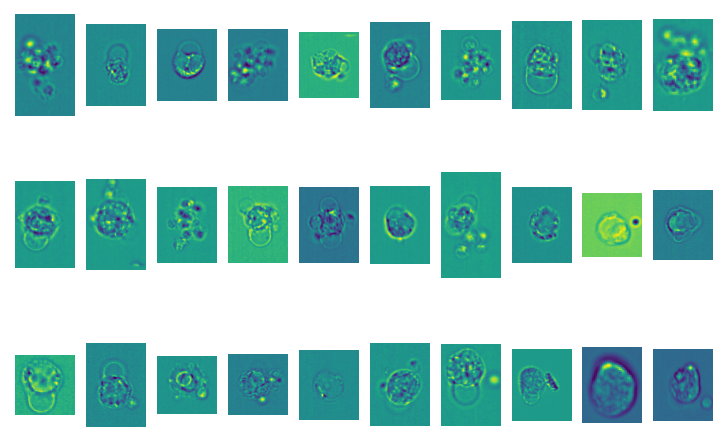

In [48]:
sel1 = (df["feat_area_BF1"] - df["feat_convex_area_BF1"]) < -200
core.plot_gate_zarr(sel1, df, maxn=30)

In [49]:
df = df[~sel1]
df.shape

(238749, 2515)

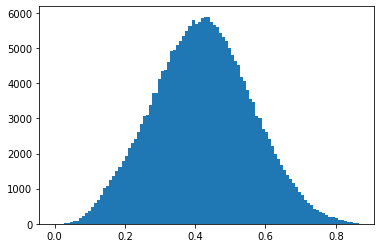

In [50]:
_ = plt.hist(df["feat_eccentricity_BF1"], bins=100)

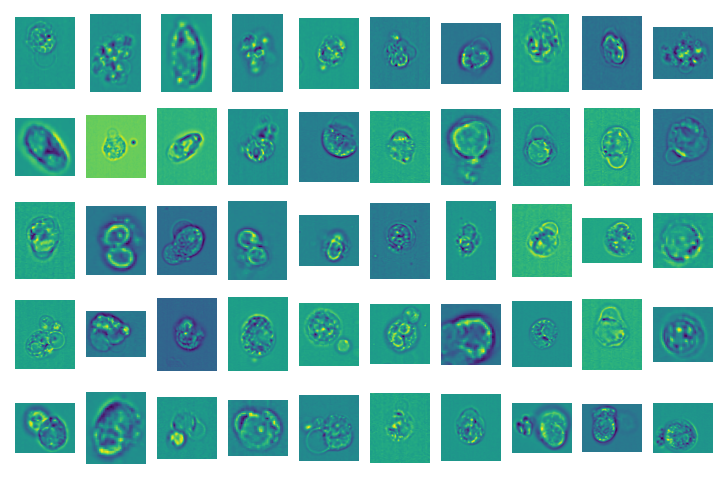

In [52]:
sel1 = df["feat_eccentricity_BF1"] > 0.7
core.plot_gate_zarr(sel1, df, maxn=50)

In [53]:
df = df[~sel1]
df.shape

(233262, 2515)

# Noisy events

In [54]:
df["feat_sobel_mean_BF1"].describe()

count    233262.000000
mean         76.691634
std          24.105990
min          11.064078
25%          59.704387
50%          75.994705
75%          91.941008
max        1005.035278
Name: feat_sobel_mean_BF1, dtype: float64

<AxesSubplot:>

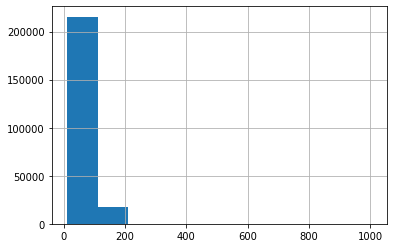

In [55]:
df["feat_sobel_mean_BF1"].hist()

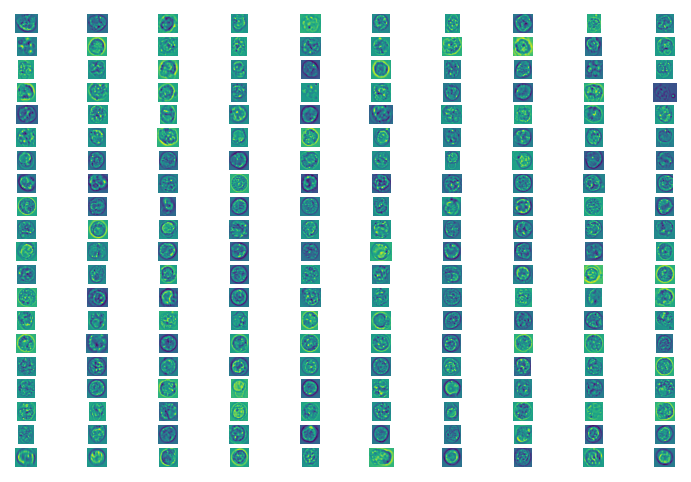

In [49]:
sel1 = df["feat_sobel_mean_BF1"] > 50
core.plot_gate_zarr(sel1, df)

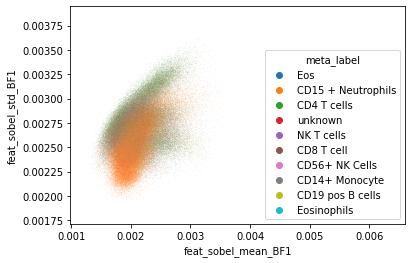

In [50]:
sel1 = df["feat_sobel_mean_BF1"] < 1
sel2 = df["feat_sobel_std_BF1"] < 1
ax = seaborn.scatterplot(data=df[sel1 & sel2], x="feat_sobel_mean_BF1", y="feat_sobel_std_BF1", s=0.1, alpha=0.5, hue="meta_label")

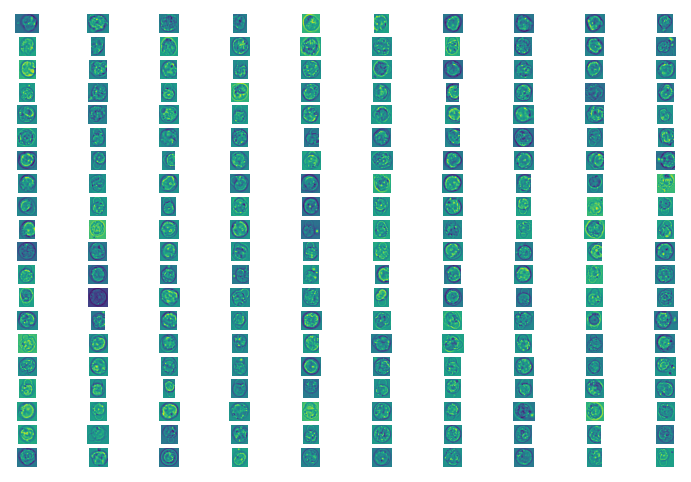

In [51]:
sel1 = df["feat_sobel_mean_BF1"] < 0.0015
core.plot_gate_zarr(sel1, df)

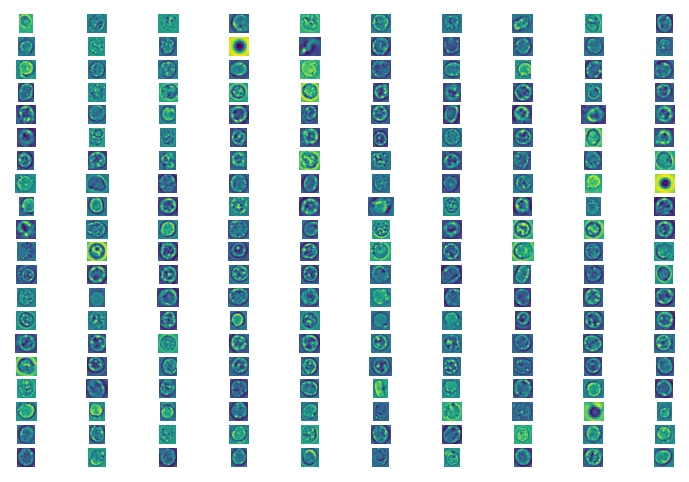

In [52]:
sel1 = df["feat_sobel_mean_BF1"] > 0.003
core.plot_gate_zarr(sel1, df)

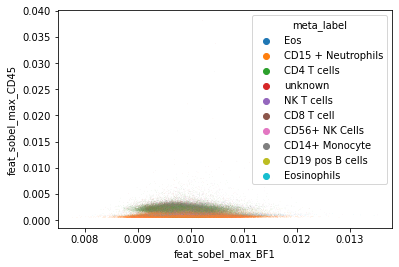

In [53]:
sel1 = df["feat_sobel_max_BF1"] < 1
sel2 = df["feat_sobel_max_CD45"] < 1
ax = seaborn.scatterplot(data=df[sel1 & sel2], x="feat_sobel_max_BF1", y="feat_sobel_max_CD45", s=0.1, alpha=0.5, hue="meta_label")

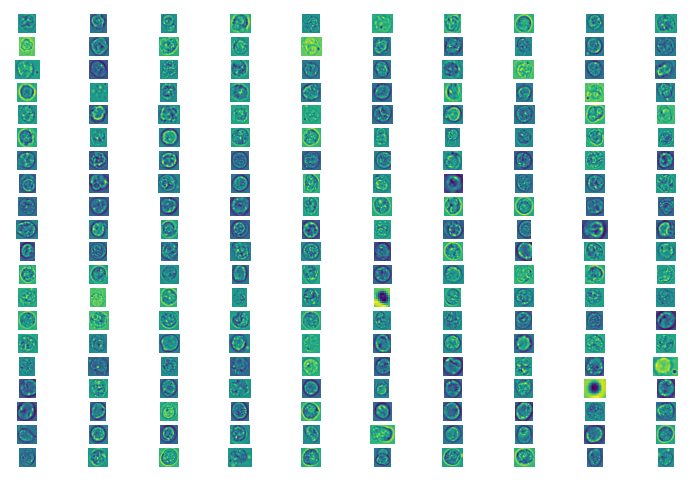

In [54]:
sel1 = df["feat_sobel_max_BF1"] > 0.012
core.plot_gate_zarr(sel1, df)

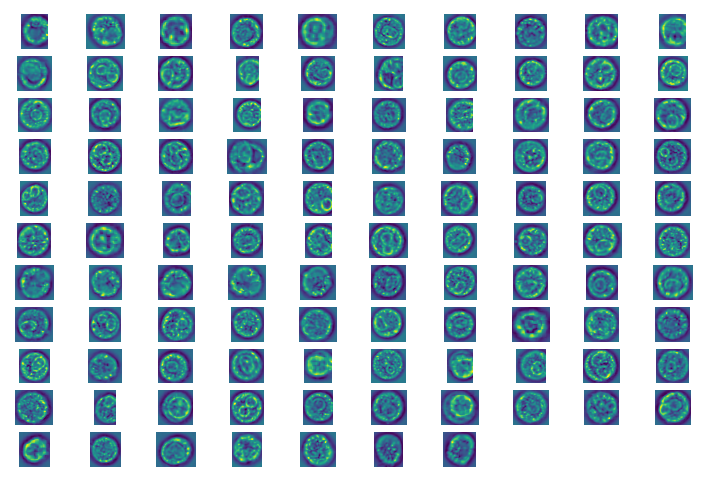

In [55]:
sel1 = df["feat_sobel_max_BF1"] < 0.0085
core.plot_gate_zarr(sel1, df)

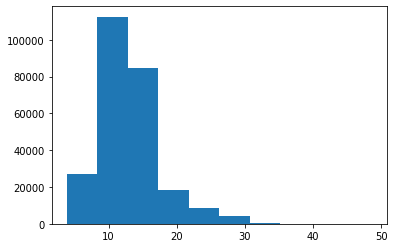

In [56]:
_ = plt.hist(df["feat_glcm_mean_contrast_5_BF1"])

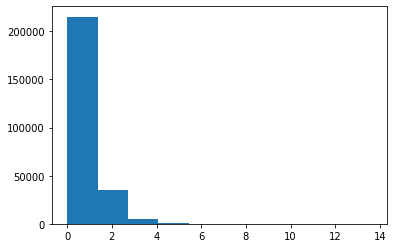

In [57]:
_ = plt.hist(df["feat_glcm_std_contrast_5_BF1"])

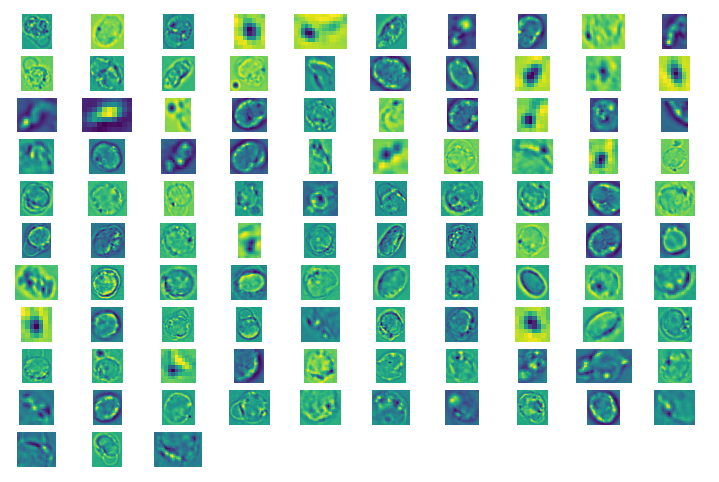

In [58]:
sel1 = df["feat_glcm_std_contrast_5_BF1"] > 6
core.plot_gate_zarr(sel1, df)

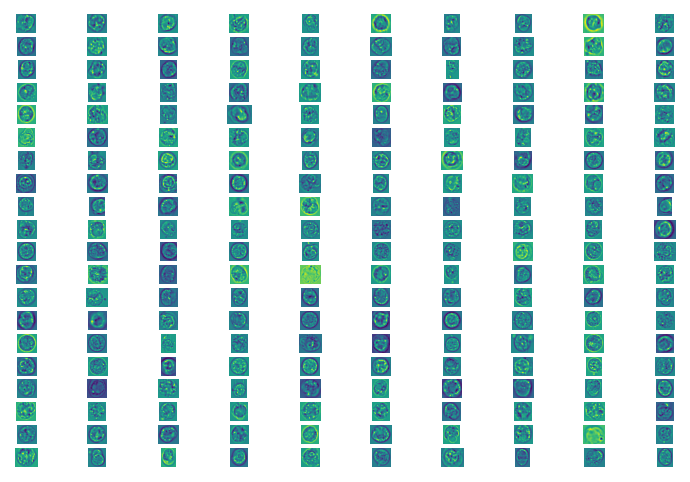

In [59]:
sel1 = df["feat_glcm_std_contrast_5_BF1"] < 1
core.plot_gate_zarr(sel1, df)

In [60]:
df["meta_label"].value_counts()

CD15 + Neutrophils    153596
CD4 T cells            37300
unknown                16769
CD8 T cell             16214
CD19 pos B cells        9753
CD56+ NK Cells          7268
NK T cells              5223
CD14+ Monocyte          5223
Eosinophils             3435
Eos                     1119
Name: meta_label, dtype: int64

# Identifying zero-variance features

In [56]:
low_var = df.filter(regex="feat").columns[df.filter(regex="feat").var() < 0.001]

In [57]:
low_var

Index(['feat_solidity_combined', 'feat_moments_central-0-1_combined',
       'feat_moments_central-1-0_combined', 'feat_moments_hu-0_combined',
       'feat_moments_hu-1_combined', 'feat_moments_hu-2_combined',
       'feat_moments_hu-3_combined', 'feat_moments_hu-4_combined',
       'feat_moments_hu-5_combined', 'feat_moments_hu-6_combined',
       ...
       'feat_glcm_mean_ASM_5_CD8', 'feat_glcm_std_ASM_3_CD8',
       'feat_glcm_std_ASM_5_CD8', 'feat_combined_glcm_std_homogeneity_3_CD8',
       'feat_combined_glcm_std_homogeneity_5_CD8',
       'feat_combined_glcm_std_energy_3_CD8',
       'feat_combined_glcm_std_energy_5_CD8',
       'feat_combined_glcm_mean_ASM_5_CD8', 'feat_combined_glcm_std_ASM_3_CD8',
       'feat_combined_glcm_std_ASM_5_CD8'],
      dtype='object', length=315)

In [58]:
df = df.drop(columns=low_var)

# Feature correlation

In [68]:
%%time
correlation = df.sample(n=10000).filter(regex="feat.*").corr()

CPU times: user 2min 36s, sys: 113 ms, total: 2min 36s
Wall time: 2min 36s


In [75]:
correlation.isna()

feat_area_BF1  feat_convex_area_BF1  \
feat_area_BF1                             False                 False   
feat_convex_area_BF1                      False                 False   
feat_eccentricity_BF1                     False                 False   
feat_equivalent_diameter_BF1              False                 False   
feat_euler_number_BF1                     False                 False   
...                                         ...                   ...   
feat_combined_glcm_std_ASM_5_CD8          False                 False   
feat_combined_sobel_mean_CD8              False                 False   
feat_combined_sobel_std_CD8               False                 False   
feat_combined_sobel_max_CD8               False                 False   
feat_combined_sobel_min_CD8               False                 False   

                                  feat_eccentricity_BF1  \
feat_area_BF1                                     False   
feat_convex_area_BF1                              False   
feat_eccentricity_BF1                             False   
feat_equivalent_diameter_BF1                      False   
feat_euler_number_BF1                             False   
...                                                 ...   
feat_combined_glcm_std_ASM_5_CD8                  False   
feat_combined_sobel_mean_CD8                      False   
feat_combined_sobel_std_CD8                       False   
feat_combined_sobel_max_CD8                       False   
feat_combined_sobel_min_CD8                       False   

                                  feat_equivalent_diameter_BF1  \
feat_area_BF1                                            False   
feat_convex_area_BF1                                     False   
feat_eccentricity_BF1                                    False   
feat_equivalent_diameter_BF1                             False   
feat_euler_number_BF1                                    False   
...                                                        ...   
feat_combined_glcm_std_ASM_5_CD8                         False   
feat_combined_sobel_mean_CD8                             False   
feat_combined_sobel_std_CD8                              False   
feat_combined_sobel_max_CD8                              False   
feat_combined_sobel_min_CD8                              False   

                                  feat_euler_number_BF1  \
feat_area_BF1                                     False   
feat_convex_area_BF1                              False   
feat_eccentricity_BF1                             False   
feat_equivalent_diameter_BF1                      False   
feat_euler_number_BF1                             False   
...                                                 ...   
feat_combined_glcm_std_ASM_5_CD8                  False   
feat_combined_sobel_mean_CD8                      False   
feat_combined_sobel_std_CD8                       False   
feat_combined_sobel_max_CD8                       False   
feat_combined_sobel_min_CD8                       False   

                                  feat_feret_diameter_max_BF1  \
feat_area_BF1                                           False   
feat_convex_area_BF1                                    False   
feat_eccentricity_BF1                                   False   
feat_equivalent_diameter_BF1                            False   
feat_euler_number_BF1                                   False   
...                                                       ...   
feat_combined_glcm_std_ASM_5_CD8                        False   
feat_combined_sobel_mean_CD8                            False   
feat_combined_sobel_std_CD8                             False   
feat_combined_sobel_max_CD8                             False   
feat_combined_sobel_min_CD8                             False   

                                  feat_filled_area_BF1  \
feat_area_BF1                                    False   
feat_convex_area_BF1                             

## Overall feature correlation

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


ValueError: The condensed distance matrix must contain only finite values.

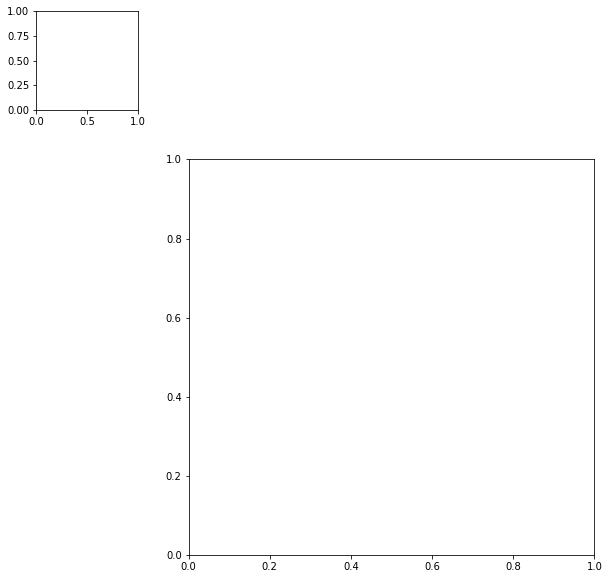

In [69]:
seaborn.clustermap(correlation)

In [157]:
def get_correlated_features(df, cutoff=0.85):
    correlation = df.corr()
    var = df.var()
    correlated_features = set()
    for i in range(correlation.shape[0]):
        for j in range(i):
            if abs(correlation.iloc[i, j]) > cutoff:
                if var[correlation.columns[i]] >= var[correlation.columns[j]]:
                    colname = correlation.columns[j]
                else:
                    colname = correlation.columns[i]
                correlated_features.add(colname)
                
    return correlated_features

In [158]:
correlated_features = get_correlated_features(df.filter(regex="feat"), cutoff=0.7)
correlation2 = df.filter(regex="feat").drop(columns=correlated_features).corr()

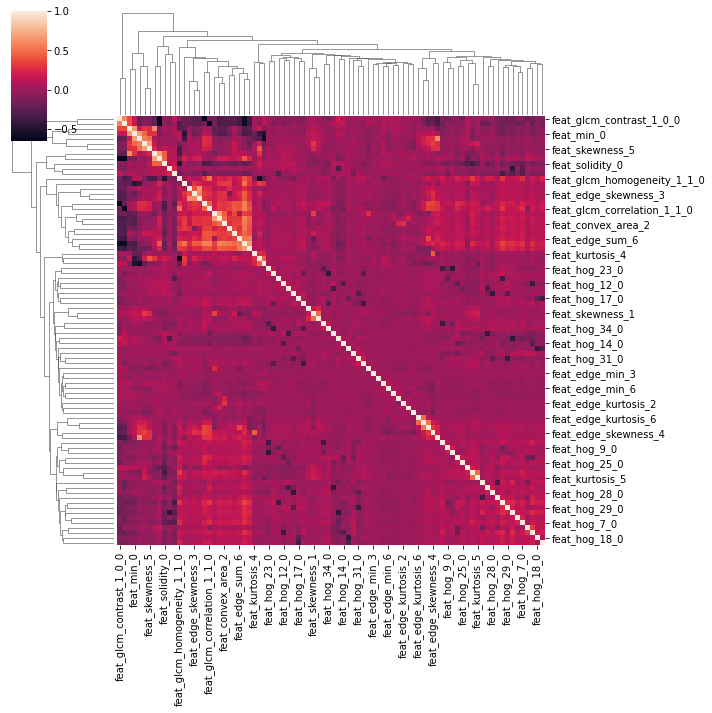

In [159]:
seaborn.clustermap(correlation2)

In [160]:
len(correlated_features)

153

In [161]:
df = df.drop(columns=correlated_features)

In [162]:
df.shape

(58440, 112)

In [163]:
len(df.index.values)

58440

# Export

In [60]:
numpy.save(data_dir / "indices/index.npy", df.index.values)

In [61]:
numpy.save(data_dir / "indices/columns.npy", df.columns.values)